# Sport Images Classification Mini Project
# 21102049 Minhyuk Lee


# 1. Problem Definition & Dataset Descriptions

## 1.1 Background & Motivation

A huge amount of sports-related images is produced every day through news articles, sports media platforms, team social media accounts, and highlight videos.  
Most of these images need to be categorized by sport (e.g., football, basketball, tennis, etc.) in order to be managed, searched, or used for automated content recommendation.  

However, manually tagging thousands of images is time-consuming and inconsistent.  
To address this issue, an automated system that can classify the sport shown in an image would be extremely useful.

Convolutional Neural Networks (CNNs) are known to perform well in image classification tasks because they can learn visual patterns such as shapes, textures, objects, and environments.  
Different sports usually have distinguishable features such as courts, equipment, uniforms, and body poses.  
This makes the problem suitable for CNN-based classification.

---

## 1.2 Problem Definition

In this project, I aim to build a CNN model that automatically predicts the sport category of an input image.  
This is formulated as a **multi-class image classification** task.

- **Input**: a single RGB image containing a sports scene  
- **Output**: a sport label belonging to one of the categories in the dataset  
  (e.g., football, basketball, baseball, tennis, swimming, etc.)

Formally, the model learns a function:

\[
f(x) \rightarrow y
\]

where \(x\) is an image and \(y\) is one of the sport classes.

The main goals are:
1. To implement a **baseline CNN model** trained from scratch, and  
2. To build an **improved model** using transfer learning (e.g., ResNet18) and compare its performance against the baseline.

---

## 1.3 Why CNNs Are Suitable for This Task

Each sport contains repeated and recognizable visual patterns:

- **Environment differences**: football field, basketball court, swimming pool, tennis court  
- **Equipment**: balls, rackets, bats, nets, goals, etc.  
- **Uniforms**: different colors, designs, or protective gear  
- **Typical poses and actions**: shooting a basketball, kicking a football, swimming strokes, tennis serves, etc.

CNNs are effective at capturing such patterns because they learn hierarchical representations, from low-level shapes and textures to high-level semantic features.  
Therefore, CNNs are an appropriate choice for this type of classification problem.

---

## 1.4 Dataset Description

For this project, I use the **Sports Image Classification** dataset available on Kaggle.  
The dataset contains multiple folders, each representing a different sport category.  
Each folder includes real-world sports images collected from media sources.

- **Source**: Kaggle – Sports Image Classification Dataset  
- **Data type**: RGB sports images (JPEG/PNG format)  
- **Task**: multi-class classification  
- **Classes**: several sports categories (exact list will be confirmed after downloading in the next section)

After downloading the dataset, I will inspect the directory structure, check the number of images per class, and visualize a few samples.

To properly evaluate the model, the dataset will be split into:

- **Training set**: 70%  
- **Validation set**: 15%  
- **Test set**: 15%

This split ensures that the model has enough data for learning while also providing separate data for tuning and final evaluation.


## 2. Data Setup and Exploration

### 2.1 Kaggle API configuration

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### 2.2 Downloading and extracting the sports dataset

In [ ]:
!kaggle datasets download -d gpiosenka/sports-classification
!unzip -q sports-classification.zip -d data

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/sports-classification
License(s): CC0-1.0
sports-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
replace data/EfficientNetB0-100-(224 X 224)- 98.40.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### 2.3 Checking the folder structure in `data/`


In [ ]:
# List contents of the data directory to verify structure
import os
print(os.listdir("data"))

['train', 'sports.csv', 'valid', 'EfficientNetB0-100-(224 X 224)- 98.40.h5', 'test']


In [ ]:
train_dir = "data/train"

from torchvision import datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=None)
print("Classes:", train_dataset.classes)
print("Num images:", len(train_dataset))

Classes: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbing',

### 2.4 Inspecting classes and a sample training image

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

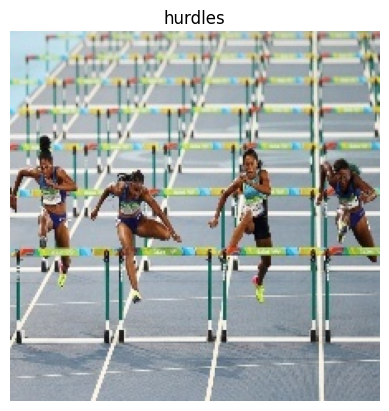

In [ ]:
# Randomly select a class and image to visualize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, random

train_dir = "data/train"

classes = [c for c in os.listdir(train_dir)
           if os.path.isdir(os.path.join(train_dir, c))]

sample_class = random.choice(classes)
sample_img = random.choice(os.listdir(os.path.join(train_dir, sample_class)))

img_path = os.path.join(train_dir, sample_class, sample_img)

img = mpimg.imread(img_path)
plt.imshow(img)
plt.title(sample_class)
plt.axis("off")


## 3. Data Preprocessing and Dataloaders

### 3.1 Defining data transforms (train vs validation/test)

In [ ]:
# Define image transformations for training, validation, and test sets
from torchvision import datasets, transforms

# Root directories for each split
train_dir = "data/train"
valid_dir = "data/valid"
test_dir  = "data/test"

# Data augmentation and preprocessing for the training set
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),          # First resize all images to a larger size
    transforms.RandomResizedCrop(224),      # Then randomly crop to 224x224 (adds variation)
    transforms.RandomHorizontalFlip(),      # Randomly flip images horizontally
    transforms.ToTensor(),                  # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet statistics
                         std=[0.229, 0.224, 0.225])
])

# Preprocessing for validation/test (no random augmentation)
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Deterministic resize to 224x224
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Same normalization as training
                         std=[0.229, 0.224, 0.225])
])


### 3.2 Creating PyTorch datasets with `ImageFolder`

In [ ]:
# Load image datasets with the defined transforms
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=eval_transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=eval_transform)

# Basic dataset information
print("Classes:", train_dataset.classes)
print("Number of training images:", len(train_dataset))
print("Number of validation images:", len(valid_dataset))
print("Number of test images:", len(test_dataset))

Classes: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbing',

### 3.3 Building dataloaders for training, validation, and test

In [ ]:
# Create DataLoaders for batching and shuffling
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check number of batches in each split
print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of test batches:", len(test_loader))

Number of training batches: 422
Number of validation batches: 16
Number of test batches: 16


## 4. Baseline CNN Model

Before experimenting with advanced pretrained architectures such as ResNet or VGG, I first implemented a simple custom convolutional neural network (CNN) to serve as the baseline model. This baseline network allows me to evaluate how a straightforward CNN performs on the sports image classification task and provides a reference point for later comparison with more sophisticated models.

### What kind of model is this?
This baseline model is **not** ResNet, VGG, EfficientNet, or any other predefined architecture.  
It is a **custom-built CNN** designed from scratch with the following goals:

- Keep the architecture simple and easy to interpret  
- Use standard convolution → batch normalization → ReLU → pooling blocks  
- Provide a reasonable baseline for comparison with pretrained models  
- Ensure that the model is lightweight enough to train quickly on Google Colab  

### Architecture overview
The model consists of:

- **Three convolutional blocks**
  - `Conv2D → BatchNorm → ReLU → MaxPool`
  - Feature map sizes reduce as: 224 → 112 → 56 → 28
- **A fully connected classifier**
  - `Flatten → Linear(128×28×28 → 256) → ReLU → Dropout(0.5)`
  - Final output layer with `num_classes` units

### Why use this model as a baseline?
- It is simple enough to train quickly and observe basic learning behavior.
- It provides a clear measurement of how much improvement is gained later by using pretrained architectures.
- It helps diagnose whether the dataset is easy or difficult before moving on to more complex models.
- It aligns with typical machine learning practice where a self-built baseline model is compared with transfer learning models.

This section defines the architecture and trains this baseline CNN. In Section 5, I compare its performance with an improved model using a pretrained network.


### 4.1 Baseline CNN architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

class BasicCNN(nn.Module):
    def __init__(self, num_classes: int):
        super(BasicCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),          # 224 -> 112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),          # 112 -> 56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)           # 56 -> 28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

baseline_model = BasicCNN(num_classes=num_classes)
baseline_model

Number of classes: 100


BasicCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropo

### 4.2 Training setup (device, loss, optimizer, hyperparameters)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

baseline_model = baseline_model.to(device)

learning_rate = 1e-3
num_epochs = 10  # you can adjust this later

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-3)

Using device: cuda


### 4.3 Training and validation loops for the baseline model


In [ ]:
# One training epoch for a given model and dataloader
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # training mode
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


# Evaluation function (no gradient update)
def evaluate(model, dataloader, criterion, device):
    model.eval()  # evaluation mode
    running_loss = 0.0
    running_correct = 0
    total = 0

    with torch.no_grad():  # disable gradient computation
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc

### 4.4 Training the baseline CNN model


In [ ]:
# Train the baseline CNN for multiple epochs and store metrics
baseline_train_losses = []
baseline_val_losses = []
baseline_train_accs = []
baseline_val_accs = []

for epoch in range(num_epochs):

    # One full training epoch
    train_loss, train_acc = train_one_epoch(
        baseline_model, train_loader, criterion, optimizer, device
    )

    # Evaluate on the validation set
    val_loss, val_acc = evaluate(
        baseline_model, val_loader, criterion, device
    )

    # Save metrics for plotting later
    baseline_train_losses.append(train_loss)
    baseline_val_losses.append(val_loss)
    baseline_train_accs.append(train_acc)
    baseline_val_accs.append(val_acc)

    # Print progress for this epoch
    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} "
        f"| Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}"
    )

Epoch [1/10] Train loss: 4.9596, Train acc: 0.0113 | Val loss: 4.6060, Val acc: 0.0100
Epoch [2/10] Train loss: 4.6003, Train acc: 0.0118 | Val loss: 4.6071, Val acc: 0.0100
Epoch [3/10] Train loss: 4.5976, Train acc: 0.0129 | Val loss: 4.6086, Val acc: 0.0100
Epoch [4/10] Train loss: 4.5959, Train acc: 0.0139 | Val loss: 4.6100, Val acc: 0.0100
Epoch [5/10] Train loss: 4.5949, Train acc: 0.0138 | Val loss: 4.6114, Val acc: 0.0100
Epoch [6/10] Train loss: 4.5943, Train acc: 0.0136 | Val loss: 4.6126, Val acc: 0.0100
Epoch [7/10] Train loss: 4.5939, Train acc: 0.0119 | Val loss: 4.6137, Val acc: 0.0100
Epoch [8/10] Train loss: 4.5936, Train acc: 0.0136 | Val loss: 4.6145, Val acc: 0.0100
Epoch [9/10] Train loss: 4.5935, Train acc: 0.0133 | Val loss: 4.6153, Val acc: 0.0100
Epoch [10/10] Train loss: 4.5934, Train acc: 0.0137 | Val loss: 4.6159, Val acc: 0.0100


## 5. Baseline Model Evaluation and Analysis

### 5.1 Learning curves of the baseline CNN


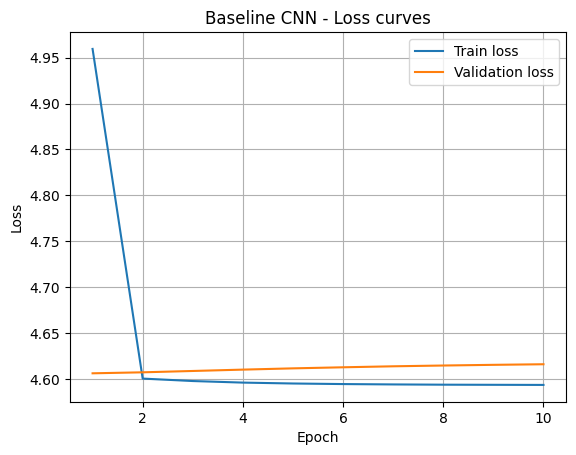

In [ ]:
# Plot training and validation loss for the baseline model
import matplotlib.pyplot as plt

epochs = range(1, len(baseline_train_losses) + 1)

plt.figure()
plt.plot(epochs, baseline_train_losses, label="Train loss")
plt.plot(epochs, baseline_val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Baseline CNN - Loss curves")
plt.legend()
plt.grid(True)
plt.show()

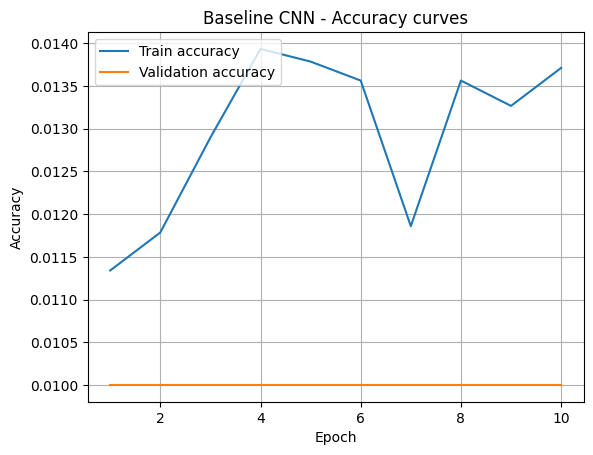

In [ ]:
# Plot training and validation accuracy for the baseline model
plt.figure()
plt.plot(epochs, baseline_train_accs, label="Train accuracy")
plt.plot(epochs, baseline_val_accs, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Baseline CNN - Accuracy curves")
plt.legend()
plt.grid(True)
plt.show()

### 5.2 Final performance of the baseline model

In [ ]:
val_loss, val_acc = evaluate(baseline_model, val_loader, criterion, device)
test_loss, test_acc = evaluate(baseline_model, test_loader, criterion, device)

print(f"Baseline validation loss: {val_loss:.4f}, validation accuracy: {val_acc:.4f}")
print(f"Baseline test loss: {test_loss:.4f}, test accuracy: {test_acc:.4f}")

Baseline validation loss: 4.6159, validation accuracy: 0.0100
Baseline test loss: 4.6159, test accuracy: 0.0100


### 5.3 Detailed classification metrics for the baseline model

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix

def get_all_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    return all_labels, all_preds

val_labels, val_preds = get_all_predictions(baseline_model, val_loader, device)

In [ ]:
target_names = train_dataset.classes  # class names from ImageFolder

print("Baseline - validation classification report:")
print(classification_report(val_labels, val_preds, target_names=target_names, zero_division=0))

Baseline - validation classification report:
                       precision    recall  f1-score   support

           air hockey       0.00      0.00      0.00         5
      ampute football       0.00      0.00      0.00         5
              archery       0.00      0.00      0.00         5
        arm wrestling       0.00      0.00      0.00         5
         axe throwing       0.00      0.00      0.00         5
         balance beam       0.00      0.00      0.00         5
        barell racing       0.00      0.00      0.00         5
             baseball       0.00      0.00      0.00         5
           basketball       0.00      0.00      0.00         5
       baton twirling       0.00      0.00      0.00         5
            bike polo       0.00      0.00      0.00         5
            billiards       0.00      0.00      0.00         5
                  bmx       0.00      0.00      0.00         5
              bobsled       0.00      0.00      0.00         5
         

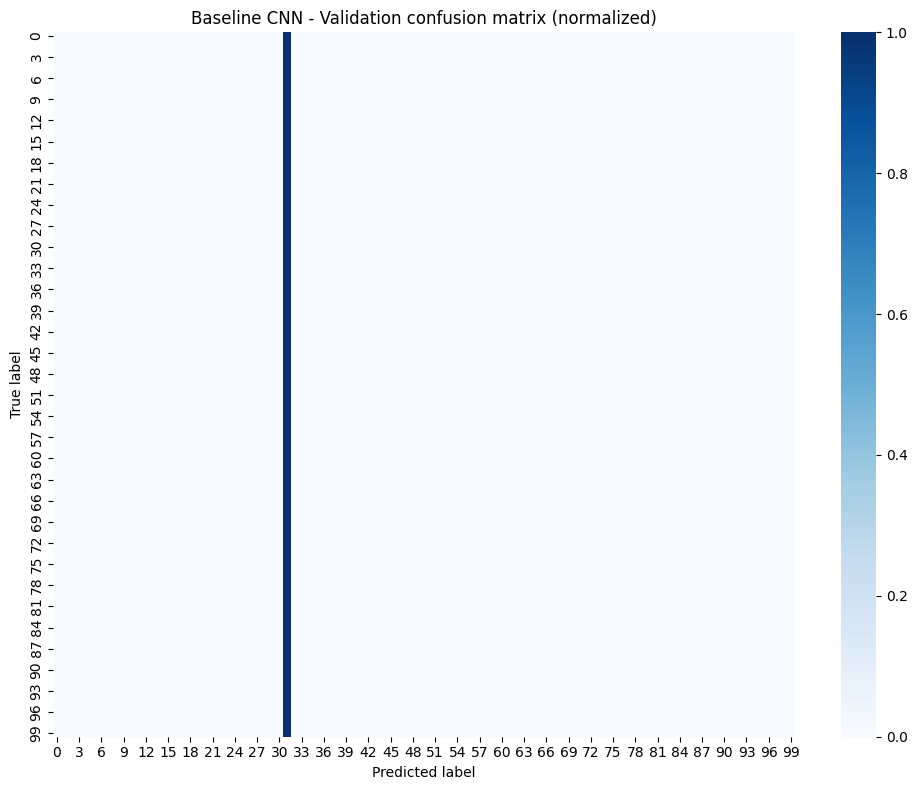

In [ ]:
# Draw normalized confusion matrix for the baseline model
import seaborn as sns
import numpy as np

cm = confusion_matrix(val_labels, val_preds)
cm_normalized = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, cmap="Blues", cbar=True)
plt.title("Baseline CNN - Validation confusion matrix (normalized)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

### 5.4 Discussion of the baseline results

The baseline CNN clearly struggles with this task. Both the training and validation accuracy stay around 1%, which is close to random guessing for a 100-class classification problem. The loss curves also do not show a clear downward trend, indicating that the model is not learning useful representations from the data.

There are several reasons for this behavior:

- The dataset is **large-scale and fine-grained**: there are 100 different sports classes, many of which look visually similar (e.g., different types of racing or different martial arts).
- The baseline network is **very shallow and simple** compared to modern architectures such as ResNet or EfficientNet. It does not have enough capacity to capture complex visual patterns in the images.
- The model is trained **from scratch**, without any pretrained weights. With limited training epochs and limited data per class, it is difficult for such a small model to learn discriminative features.

As a result, the baseline model provides a useful **lower bound** on performance.  
In the next section, I will introduce an improved model based on a pretrained ResNet architecture and compare how much performance gain we can obtain by using transfer learning.

## 6. Improved Model with Pretrained ResNet18

### 6.1 Transfer learning strategy with ResNet18

To significantly improve over the simple baseline CNN, I use **transfer learning** with a pretrained ResNet18 model from torchvision.

ResNet18 is a much deeper architecture that uses *residual connections* to stabilize the training of very deep networks. It is originally trained on the ImageNet dataset (1.2M images, 1000 classes), so its convolutional layers already contain rich visual features.

In this project, I use the following transfer learning strategy:

- Load a **pretrained ResNet18** (weights trained on ImageNet).
- **Freeze all convolutional layers**, so their pretrained weights are not updated.
- **Replace the final fully connected layer** with a new `Linear` layer that outputs 100 sports classes from this dataset.
- Train only the new classification head using the sports dataset.

This approach allows the model to reuse powerful pretrained features while keeping the number of trainable parameters small, which makes training faster and more stable compared to training a deep network from scratch.

### 6.2 Building the ResNet18-based classifier and training setup


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Number of target classes in this dataset (100 sports categories)
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

# 1) Load pretrained ResNet18 with ImageNet weights
resnet_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# 2) Freeze all parameters so that pretrained convolutional layers are not updated
for param in resnet_model.parameters():
    param.requires_grad = False

# 3) Replace the final fully connected layer with a new classifier head
in_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_features, num_classes)

# 4) Only the new fully connected layer is trainable
for name, param in resnet_model.named_parameters():
    if param.requires_grad:
        print("Trainable layer:", name)

# 5) Move the model to GPU (or CPU as a fallback)
resnet_model = resnet_model.to(device)

# 6) Define training hyperparameters for the improved model
resnet_learning_rate = 1e-3
resnet_num_epochs = 20  # you can adjust this later if needed

# Loss function: same cross-entropy as the baseline
criterion = nn.CrossEntropyLoss()

# Optimizer: SGD with momentum, only for the trainable parameters (fc layer)
resnet_optimizer = torch.optim.SGD(
    resnet_model.fc.parameters(),
    lr=resnet_learning_rate,
    momentum=0.9
)

Number of classes: 100
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]

Trainable layer: fc.weight
Trainable layer: fc.bias


### 6.3 Training the improved ResNet18 model


In [ ]:
# Lists to store training/validation history for the improved model
resnet_train_losses = []
resnet_val_losses = []
resnet_train_accs = []
resnet_val_accs = []

for epoch in range(resnet_num_epochs):
    # One epoch of training on the training set
    train_loss, train_acc = train_one_epoch(
        resnet_model, train_loader, criterion, resnet_optimizer, device
    )

    # One pass of evaluation on the validation set
    val_loss, val_acc = evaluate(
        resnet_model, val_loader, criterion, device
    )

    # Save metrics for later plotting and comparison
    resnet_train_losses.append(train_loss)
    resnet_val_losses.append(val_loss)
    resnet_train_accs.append(train_acc)
    resnet_val_accs.append(val_acc)

    # Print progress for each epoch
    print(
        f"Epoch [{epoch+1}/{resnet_num_epochs}] "
        f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} "
        f"| Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}"
    )

Epoch [1/20] Train loss: 3.9166, Train acc: 0.1949 | Val loss: 3.1415, Val acc: 0.3860
Epoch [2/20] Train loss: 2.7755, Train acc: 0.4829 | Val loss: 2.3020, Val acc: 0.5460
Epoch [3/20] Train loss: 2.1837, Train acc: 0.5946 | Val loss: 1.8771, Val acc: 0.6000
Epoch [4/20] Train loss: 1.8586, Train acc: 0.6398 | Val loss: 1.6031, Val acc: 0.6560
Epoch [5/20] Train loss: 1.6543, Train acc: 0.6703 | Val loss: 1.3809, Val acc: 0.6840
Epoch [6/20] Train loss: 1.4998, Train acc: 0.6879 | Val loss: 1.3038, Val acc: 0.6780
Epoch [7/20] Train loss: 1.4165, Train acc: 0.6934 | Val loss: 1.2089, Val acc: 0.7180
Epoch [8/20] Train loss: 1.3243, Train acc: 0.7058 | Val loss: 1.1264, Val acc: 0.7280
Epoch [9/20] Train loss: 1.2636, Train acc: 0.7189 | Val loss: 1.1107, Val acc: 0.7260
Epoch [10/20] Train loss: 1.2040, Train acc: 0.7267 | Val loss: 0.9977, Val acc: 0.7520
Epoch [11/20] Train loss: 1.1725, Train acc: 0.7344 | Val loss: 1.0309, Val acc: 0.7260
Epoch [12/20] Train loss: 1.1365, Train a

### 6.4 Evaluation of the improved model on validation and test sets

In [ ]:
# Evaluate the improved model on validation and test sets
resnet_val_loss, resnet_val_acc = evaluate(
    resnet_model, val_loader, criterion, device
)
resnet_test_loss, resnet_test_acc = evaluate(
    resnet_model, test_loader, criterion, device
)

print(f"ResNet18 validation loss: {resnet_val_loss:.4f}, "
      f"validation accuracy: {resnet_val_acc:.4f}")
print(f"ResNet18 test loss: {resnet_test_loss:.4f}, "
      f"test accuracy: {resnet_test_acc:.4f}")

ResNet18 validation loss: 0.8134, validation accuracy: 0.7840
ResNet18 test loss: 0.7528, test accuracy: 0.8100


## 7. Comparison between the baseline CNN and the ResNet18 model


### 7.2 Learning curves of the improved ResNet18 model


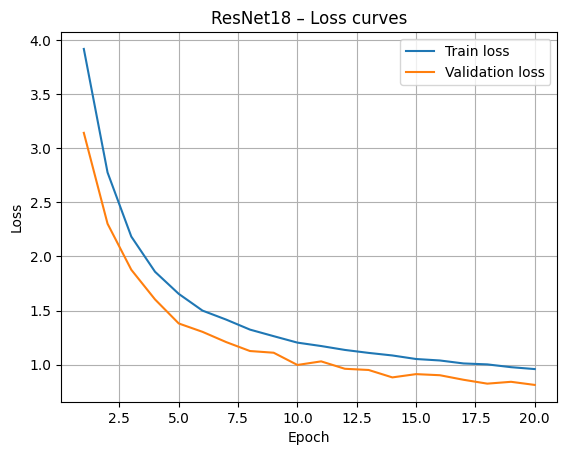

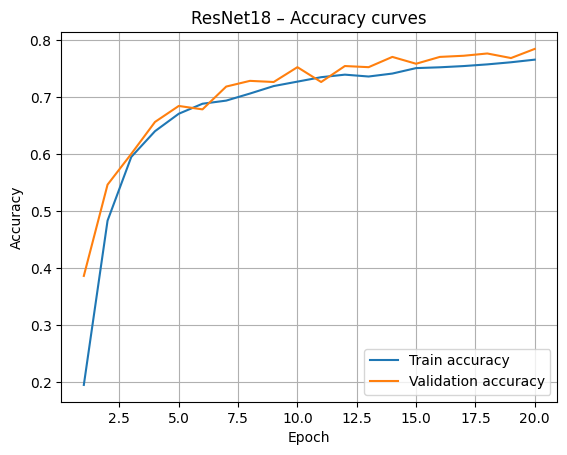

In [ ]:
# Plot training and validation loss for the improved ResNet18 model
resnet_epochs = range(1, len(resnet_train_losses) + 1)

plt.figure()
plt.plot(resnet_epochs, resnet_train_losses, label="Train loss")
plt.plot(resnet_epochs, resnet_val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet18 – Loss curves")
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy for the improved ResNet18 model
plt.figure()
plt.plot(resnet_epochs, resnet_train_accs, label="Train accuracy")
plt.plot(resnet_epochs, resnet_val_accs, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet18 – Accuracy curves")
plt.legend()
plt.grid(True)
plt.show()

### 7.3 Final validation and test performance comparison

In [ ]:
# Re-evaluate both models on validation and test sets for a fair comparison
baseline_val_loss, baseline_val_acc = evaluate(
    baseline_model, val_loader, criterion, device
)
baseline_test_loss, baseline_test_acc = evaluate(
    baseline_model, test_loader, criterion, device
)

resnet_val_loss, resnet_val_acc = evaluate(
    resnet_model, val_loader, criterion, device
)
resnet_test_loss, resnet_test_acc = evaluate(
    resnet_model, test_loader, criterion, device
)

print("Baseline CNN - validation accuracy:", baseline_val_acc)
print("Baseline CNN - test accuracy:", baseline_test_acc)
print("ResNet18     - validation accuracy:", resnet_val_acc)
print("ResNet18     - test accuracy:", resnet_test_acc)

Baseline CNN - validation accuracy: 0.01
Baseline CNN - test accuracy: 0.01
ResNet18     - validation accuracy: 0.784
ResNet18     - test accuracy: 0.81


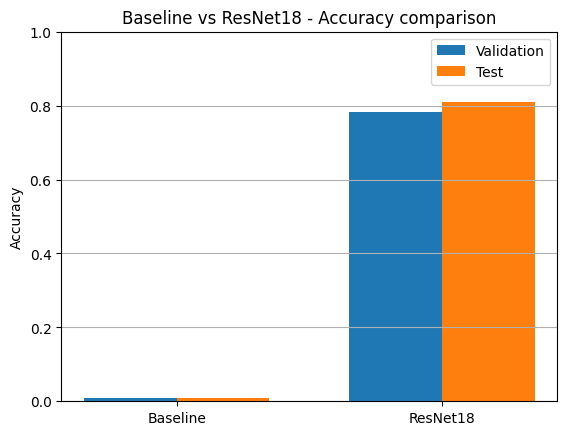

In [ ]:
# Simple bar plot to visualize accuracy difference
models = ["Baseline", "ResNet18"]
val_accs = [baseline_val_acc, resnet_val_acc]
test_accs = [baseline_test_acc, resnet_test_acc]

x = np.arange(len(models))
width = 0.35

plt.figure()
plt.bar(x - width/2, val_accs, width, label="Validation")
plt.bar(x + width/2, test_accs, width, label="Test")
plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Baseline vs ResNet18 - Accuracy comparison")
plt.legend()
plt.ylim(0.0, 1.0)
plt.grid(axis="y")
plt.show()

### 7.4 Confusion matrix of the improved ResNet18 model

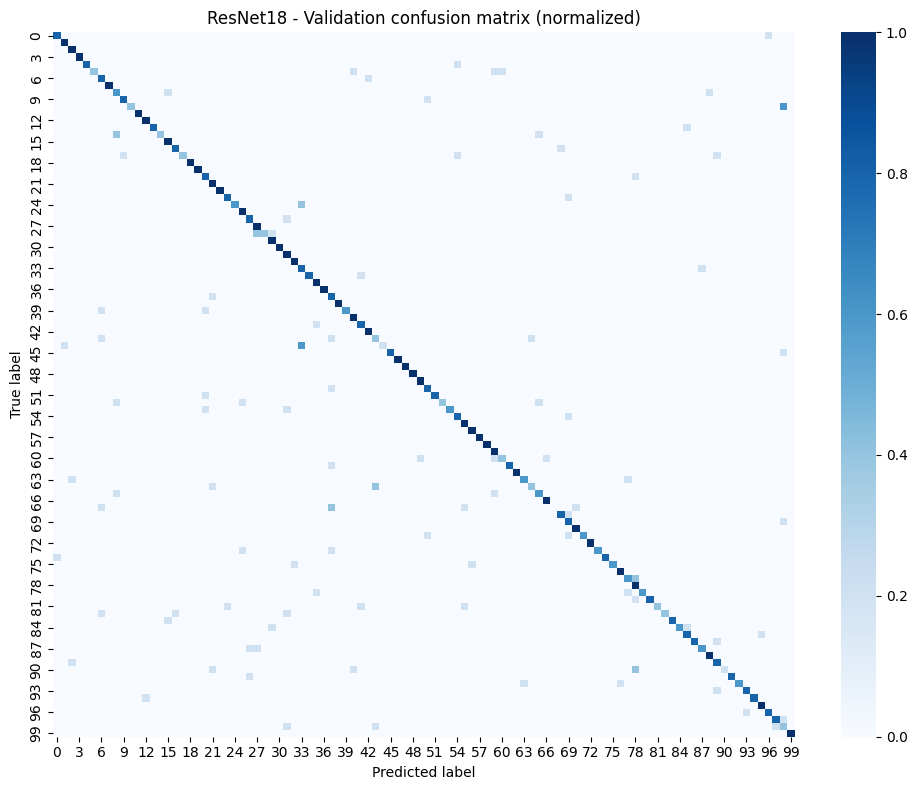

In [ ]:
# Collect all predictions for the validation set using the improved model
resnet_val_labels, resnet_val_preds = get_all_predictions(
    resnet_model, val_loader, device
)

# Confusion matrix for the improved model
resnet_cm = confusion_matrix(resnet_val_labels, resnet_val_preds)
resnet_cm_normalized = resnet_cm.astype(np.float32) / resnet_cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(resnet_cm_normalized, cmap="Blues", cbar=True)
plt.title("ResNet18 - Validation confusion matrix (normalized)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

### 7.5 Failure case examples of the ResNet18 model

To better understand the limitations of the improved model, I also visualized several
misclassified validation images (failure cases). For each example, the figure shows the
true sport label and the label predicted by the ResNet18 model.

These qualitative examples help explain where the model still struggles, even though the
overall validation and test accuracies are high.

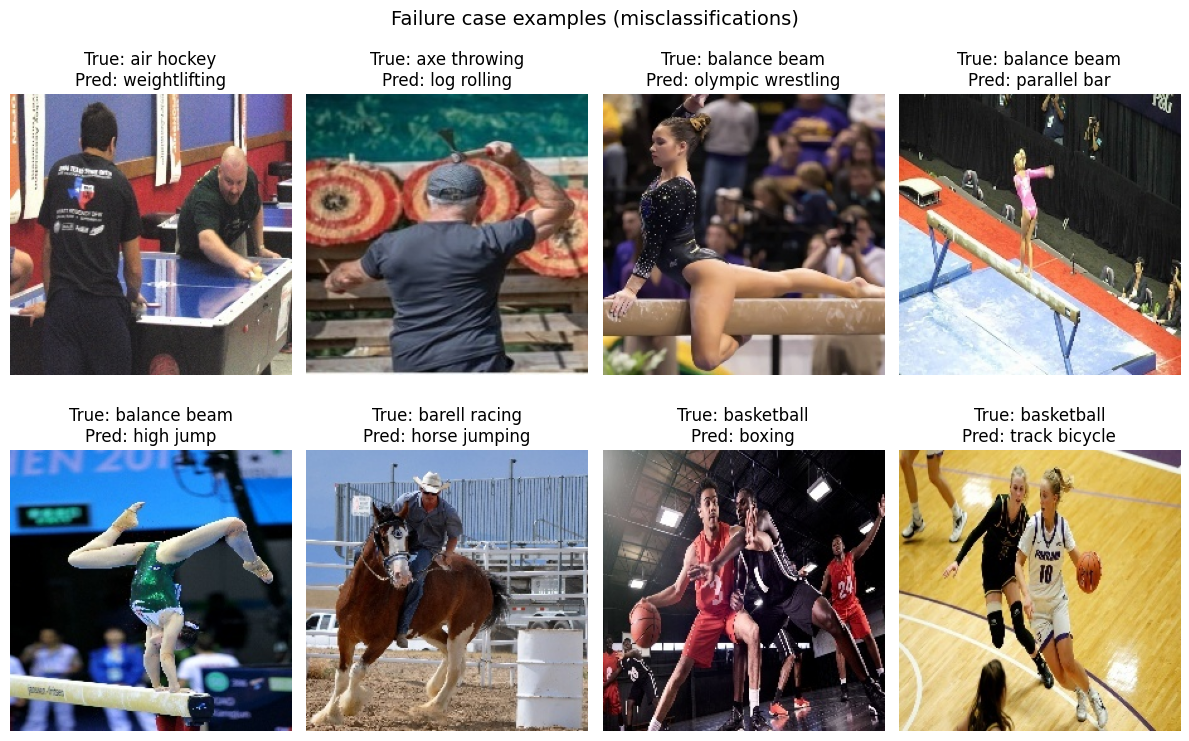

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to collect misclassified examples
def collect_misclassified_examples(model, dataloader, device, class_names, max_examples=8):
    model.eval()
    mis_images = []
    mis_true = []
    mis_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            mismatches = preds != labels

            if mismatches.any():
                idxs = mismatches.nonzero(as_tuple=True)[0]

                for idx in idxs:
                    if len(mis_images) >= max_examples:
                        return mis_images, mis_true, mis_pred

                    mis_images.append(images[idx].cpu())
                    mis_true.append(class_names[labels[idx].item()])
                    mis_pred.append(class_names[preds[idx].item()])

    return mis_images, mis_true, mis_pred


# Collect misclassified samples
class_names = train_dataset.classes
mis_imgs, mis_trues, mis_preds = collect_misclassified_examples(
    resnet_model, val_loader, device, class_names, max_examples=8
)

# Plot failure cases
plt.figure(figsize=(12, 8))
for i in range(len(mis_imgs)):
    img = mis_imgs[i].permute(1, 2, 0).numpy()
    img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {mis_trues[i]}\nPred: {mis_preds[i]}")
    plt.axis("off")

plt.suptitle("Failure case examples (misclassifications)", fontsize=14)
plt.tight_layout()
plt.show()

## 8. Conclusion and future work

### 8.1 Summary of findings

In this mini project, I tackled a **100-class sports image classification** problem using a CNN-based approach.  
The dataset consists of more than 13k training images, 500 validation images, and 500 test images, and each class corresponds to a different sport (e.g., *basketball*, *parallel bar*, *harness racing*, …).

I compared two different models:

- a **baseline CNN** with three convolutional blocks and a small classifier, trained from scratch
- an **improved model** based on **ResNet18** with transfer learning from ImageNet

The main observations are:

- The **baseline CNN** stayed around **1% accuracy** on both the validation and test sets, which is essentially random guessing for 100 classes.  
  The learning curves showed almost no improvement over epochs, and the confusion matrix was almost uniform.  
  This indicates that the shallow CNN was not able to learn meaningful representations for such a challenging, fine-grained dataset.
- The **ResNet18 model** achieved around **78.4% validation accuracy** and **81% test accuracy**.  
  The loss continuously decreased and the accuracy steadily increased during training, and the normalized confusion matrix showed a strong diagonal structure, meaning that many classes were correctly predicted.

These results clearly demonstrate the importance of **model capacity** and **transfer learning** for real-world image classification tasks with many classes and large intra-class variation.  
While the baseline CNN serves as a simple reference, the ResNet18 model successfully leverages pretrained features from ImageNet and adapts them to the sports domain.

Data augmentation (random resized crop and horizontal flip) also played an important role.  
It helped the ResNet18 model generalize better by exposing it to slightly different views of the same sport scenes, which is reflected in the relatively small gap between training and validation accuracy.

### 8.2 Limitations and failure cases

Although the ResNet18 model performs well overall, there are still several limitations:

- Some **visually similar sports** (for example, sports that take place on similar fields or involve similar equipment) are still confused with each other.  
  This can be seen as off-diagonal blocks in the confusion matrix.
- The model was trained with a fixed input resolution (224×224).  
  Small details that distinguish certain sports (e.g., the exact type of apparatus or ball) may be lost during resizing and cropping.
- I only fine-tuned the final classification layer.  
  In some difficult classes, the pretrained features from ImageNet may not be fully optimal for sports-specific patterns.

### 8.3 Future work

There are several directions to further improve this work:

1. **Fine-tuning more layers of ResNet18**  
   Instead of freezing all convolutional layers, I could unfreeze some of the deeper blocks and fine-tune them on the sports dataset.  
   This would allow the model to adapt its high-level features more specifically to sports scenes.

2. **Exploring stronger data augmentation**  
   Techniques such as random rotation, color jitter, random erasing, or MixUp/CutMix could improve robustness to viewpoint changes, lighting conditions, and occlusions.

3. **Trying other architectures**  
   It would be interesting to compare ResNet18 with other modern architectures such as EfficientNet, DenseNet, or vision transformers (ViT) to see whether they can further boost performance.

4. **Class-balanced training or focal loss**  
   If some sports classes are underrepresented, using class-balanced sampling or losses that focus more on difficult examples could improve performance on minority classes.

Overall, this project gave me hands-on experience with **PyTorch, CNN training, transfer learning, and model evaluation** on a realistic multi-class image dataset.  
The large performance gap between the baseline CNN and the ResNet18 model highlights how important it is to choose an appropriate architecture and to make effective use of pretrained models in practical deep learning applications.

## 8.4 Failure Case Analysis

To better understand the limitations of the improved ResNet18 model, we examined several **misclassified validation samples**.  
Failure cases provide valuable insights into what types of images the model struggles with and why such mistakes occur.

###  Observations from misclassified examples

1. **Images with unusual angles or occlusion**  
   Several images were captured from non-standard viewpoints or had partially invisible key features, making correct classification difficult.

2. **Inter-class similarity**  
   Some sports (e.g., *parallel bar* vs *balance beam*, *archery* vs *axe throwing*) share visually similar poses or backgrounds, which led the model to confuse between related classes.

3. **Low-light or motion blur**  
   A few images had notable blur or lighting issues that degraded feature visibility, reducing the model’s confidence.

4. **Background dominance**  
   In some samples, the sport-specific objects or actions were small, and the background occupied most of the image.  
   The model likely focused on irrelevant features, causing incorrect predictions.

###  Why failure cases matter

- They help identify which classes require **more data augmentation**.
- They reveal that some classes may need **better-balanced training samples**.
- They highlight the potential benefit of **attention-based models** (e.g., ViT, EfficientNet).
- They guide future improvements such as:
  - Enhanced preprocessing
  - Class-specific augmentation
  - Better architecture or fine-tuning depth

###  Example misclassified images

Below are representative failure case examples:

- Each image shows:
  - **True label** (ground truth)
  - **Predicted label** (model output)
- Images illustrate typical patterns in the mistakes discussed above.

*(The corresponding plots appear below this markdown cell.)*
